In [123]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import os

from datetime import datetime, timedelta

from scipy import signal

from tqdm import tqdm

In [170]:
df = pd.read_csv("./MCI analysis/dataset_full_extra.csv")
# Assuming df is your DataFrame
df = df.drop(['path', 'session', 'file_left', 'file_right', 'left_data', 'right_data'], axis=1)



In [198]:
dataset = {}

for patient in df['patient_id']:
    dataset[patient] = df[df['patient_id'] == patient]

In [180]:
healthy_df = pd.DataFrame()
mci_df = pd.DataFrame()

healthy_subjects = ['mci002', 'mci003', 'mci004', 'mci005', 'mci006', 'mci007', 'mci008', 'mci009', 'mci010', 'mci011']

for patient in dataset.keys():
    dataset[patient] = dataset[patient].groupby('date').mean()
    if patient in healthy_subjects:
        healthy_df = pd.concat([healthy_df, dataset[patient]])
    else:
        mci_df = pd.concat([mci_df, dataset[patient]])


In [199]:
ndf = pd.DataFrame()
for patient in dataset.keys():
    # dataset[patient] = dataset[patient].groupby('date').mean()
    ndf = pd.concat([ndf, dataset[patient]])

In [259]:
from scipy.stats import ttest_ind

ndf = df[['activity_time', 'stride_time_right', 'cadence', 'stride_variability_right', 'cop_speed_right', 'single_support_right', 'double_support', 'patient_id', 'date' ]]
ndf.columns = ['Activity Time', 'Gait Time', 'Cadence', 'Gait Variability', 'COP Speed', 'Single Support', 'Double Support', 'patient_id', 'date']

healthy_subjects = ['mci002', 'mci003', 'mci004', 'mci005', 'mci006', 'mci007', 'mci008', 'mci009', 'mci010', 'mci011']

# # Filter the DataFrame for healthy subjects
# ndf = ndf[ndf['Activity Time'] > 0]
# ndf = ndf[ndf['Gait Time'] < 3.5]
# ndf = ndf[ndf['Gait Variability'] < 6]
ndf = ndf[ndf['COP Speed'] > 1]
ndf = ndf[ndf['Double Support'] < 1.3]
ndf = ndf[ndf['Double Support'] > 0.1]
# ndf = ndf[ndf['Cadence'] > 20]

# group by date and get the mean for each date


healthy_df = ndf[ndf['patient_id'].isin(healthy_subjects)]

# Filter the DataFrame for MCI subjects (those not in the list of healthy subjects)
mci_df = ndf[~ndf['patient_id'].isin(healthy_subjects)]

results = []

# Perform t-test for each numeric column
for column in ndf.columns:
    if column not in ['patient_id', 'date', 'session_id']:  # Exclude non-numeric columns
        # Drop NaN values from both groups
        healthy_values = healthy_df[column].dropna()
        mci_values = mci_df[column].dropna()

        # Perform the t-test
        t_stat, p_value = ttest_ind(healthy_values, mci_values, nan_policy='omit')

        # Store the results
        results.append({
            'column': column,
            't_stat': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

             column    t_stat   p_value  significant
0     Activity Time  3.045376  0.002514         True
1         Gait Time  0.472220  0.637087        False
2           Cadence  1.282631  0.200536        False
3  Gait Variability  1.236769  0.217066        False
4         COP Speed  4.016352  0.000073         True
5    Single Support  4.304875  0.000022         True
6    Double Support -3.090644  0.002170         True


In [205]:
healthy_df.reset_index(inplace=True)
mci_df.reset_index(inplace=True)

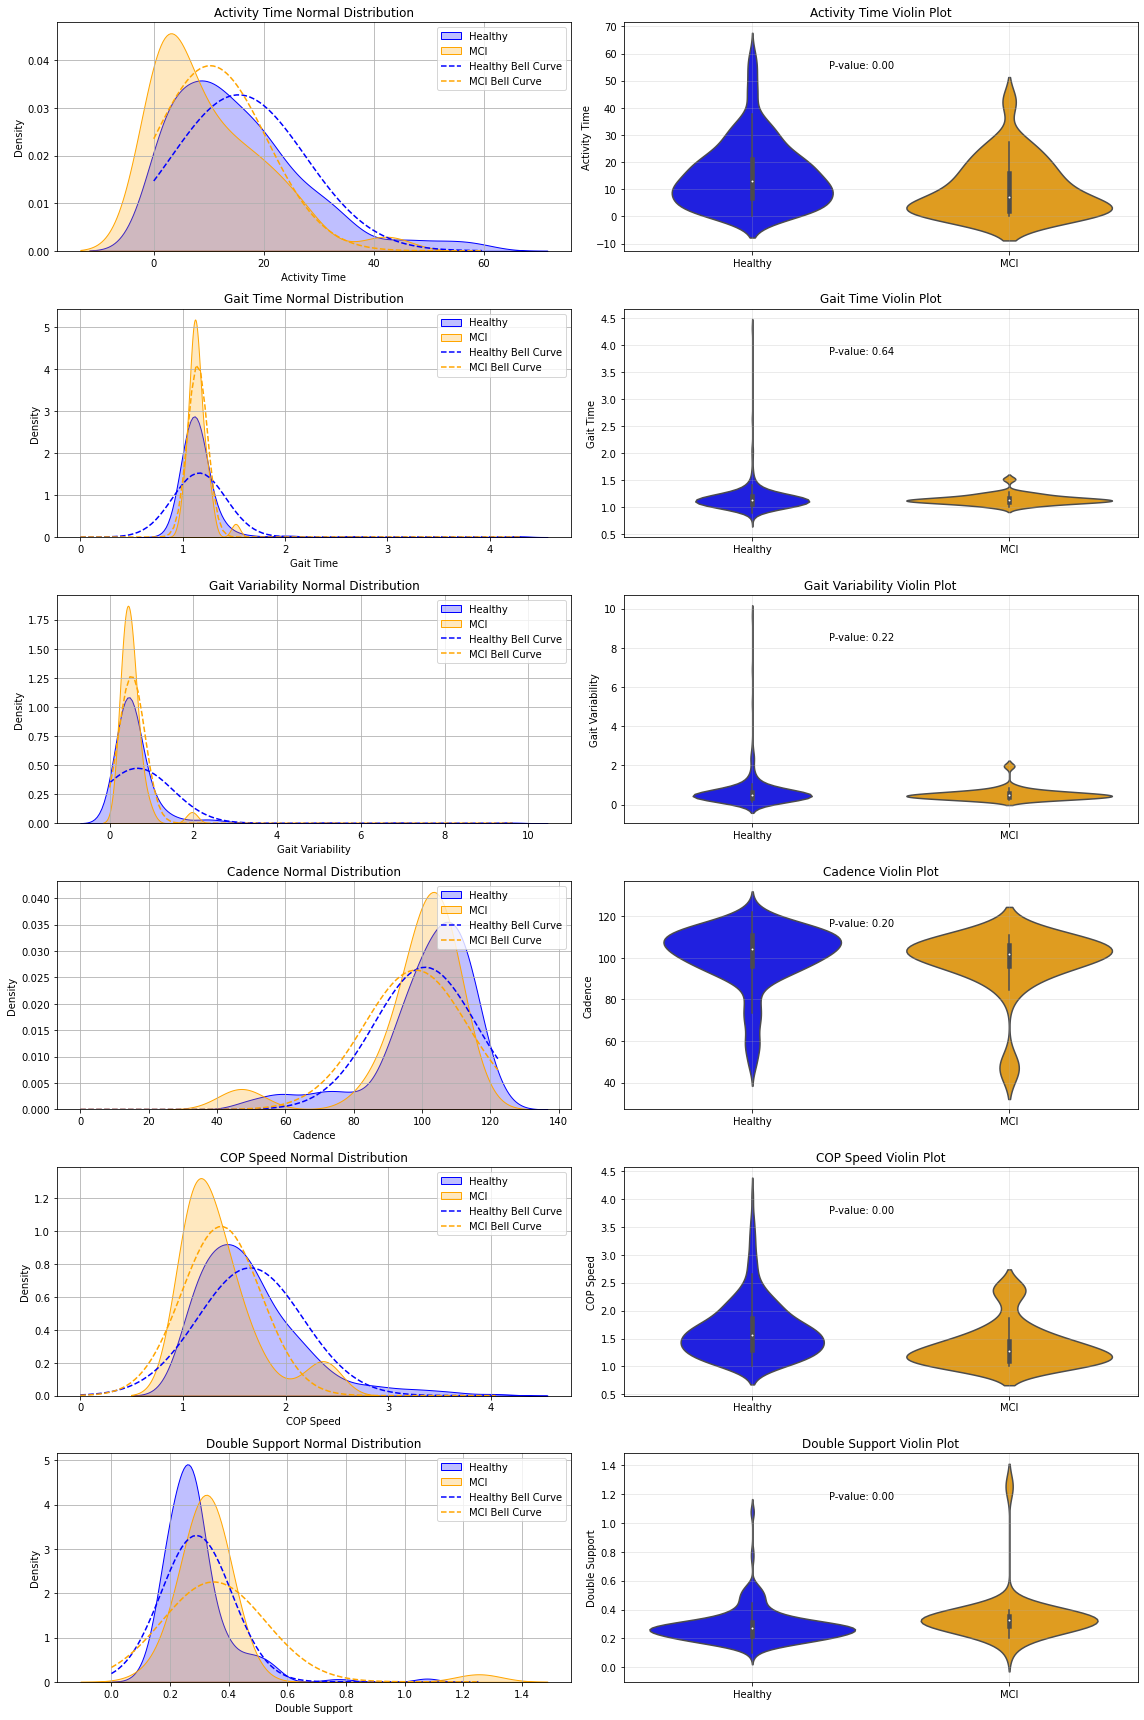

In [260]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, describe, ttest_ind

columns_to_plot = ['Activity Time', 'Gait Time', 'Gait Variability', 'Cadence', 'COP Speed', 'Double Support']
# Create subplots for each metric
fig, axs = plt.subplots(len(columns_to_plot), 2, figsize=(16, 4 * len(columns_to_plot)))

for i, column in enumerate(columns_to_plot):
    # Select the data for the two groups
    data_healthy = healthy_df[column].dropna()
    data_mci = mci_df[column].dropna()

    # Plot the PDFs for each group in the left subplot
    sns.kdeplot(data_healthy, label='Healthy', shade=True, color='blue', ax=axs[i, 0])
    sns.kdeplot(data_mci, label='MCI', shade=True, color='orange', ax=axs[i, 0])

    # Calculate the mean and standard deviation for each group
    mean_healthy, std_healthy = data_healthy.mean(), data_healthy.std()
    mean_mci, std_mci = data_mci.mean(), data_mci.std()

    # Set the lower limit for x-axis range to exclude negative values
    x_min = 0
    x_max = max(data_healthy.max(), data_mci.max())

    # Plot bell curve for each group in the left subplot
    x = np.linspace(x_min, x_max, 100)
    axs[i, 0].plot(x, norm.pdf(x, mean_healthy, std_healthy), color='blue', linestyle='--', label='Healthy Bell Curve')
    axs[i, 0].plot(x, norm.pdf(x, mean_mci, std_mci), color='orange', linestyle='--', label='MCI Bell Curve')
    
    # # Add a vertical line at the median of the healthy group
    # median_healthy = np.median(data_healthy)  # Assuming 'data_healthy' contains your healthy group data
    # axs[i, 0].axvline(median_healthy, color='blue', linestyle='-', label='Healthy Median')

    # # Add a vertical line at the median of the MCI group
    # median_mci = np.median(data_mci)  # Assuming 'data_mci' contains your MCI group data
    # axs[i, 0].axvline(median_mci, color='orange', linestyle='-', label='MCI Median')


    # Add legend and labels to the left subplot
    axs[i, 0].legend()
    axs[i, 0].set_title(f'{column} Normal Distribution')
    axs[i, 0].set_xlabel(column)
    axs[i, 0].set_ylabel('Density')

    # Perform the T-test
    t_stat, p_val = ttest_ind(data_healthy, data_mci, nan_policy='omit')

    # Add violin plot for each group in the right subplot
    sns.violinplot(data=[data_healthy, data_mci], ax=axs[i, 1], palette=['blue', 'orange'], labels=['Healthy', 'MCI'])
    axs[i, 1].set_title(f'{column} Violin Plot')
    axs[i, 1].set_xticklabels(['Healthy', 'MCI'])
    axs[i, 1].set_ylabel(column)

    axs[i, 1].text(0.4, 0.8, f"P-value: {p_val:.2f}", transform=axs[i, 1].transAxes)

    axs[i, 0].grid(visible=True, which='both', axis='both')
    axs[i, 1].grid(visible=True, which='both', alpha=0.3)

fig.tight_layout()
plt.savefig(f'./MCI analysis/plots/Double_Support.png')

In [256]:
double_support_healthy = healthy_df['Double Support'].dropna()
double_support_mci = mci_df['Double Support'].dropna()

double_support_healthy.to_csv('./MCI analysis/double_support_healthy.csv')
double_support_mci.to_csv('./MCI analysis/double_support_mci.csv')

In [251]:
# Loop through each metric and calculate the statistics
results = {'Metric': [], 'Mean_Healthy': [], 'Mean_MCI': [], 'Median_Healthy': [], 'Median_MCI': [], 'Std_Healthy': [], 'Std_MCI': [], 'Range_Healthy': [], 'Range_MCI': [], 'P-value': [], 'Significance': []}

for column in healthy_df.columns:
    if column not in ['patient_id', 'date', 'session_id']:  # Exclude non-numeric columns
        # Perform the T-test
        t_stat, p_val = ttest_ind(healthy_df[column].dropna(), mci_df[column].dropna(), nan_policy='omit')
        
        # Determine the significance level
        significance_level = 0.05
        significance = "Significant" if p_val < significance_level else "Not Significant"
        
        # Calculate descriptive statistics for each group
        desc_healthy = describe(healthy_df[column].dropna())
        desc_mci = describe(mci_df[column].dropna())
        
        # Calculate the median for each group
        median_healthy = np.median(healthy_df[column].dropna())
        median_mci = np.median(mci_df[column].dropna())
        
        # Append the results to the dictionary
        results['Metric'].append(column)
        results['Mean_Healthy'].append("{:.2f}".format(desc_healthy.mean))
        results['Mean_MCI'].append("{:.2f}".format(desc_mci.mean))
        results['Median_Healthy'].append("{:.2f}".format(median_healthy))
        results['Median_MCI'].append("{:.2f}".format(median_mci))
        results['Range_Healthy'].append("({:.2f}, {:.2f})".format(desc_healthy.minmax[0], desc_healthy.minmax[1]))
        results['Range_MCI'].append("({:.2f}, {:.2f})".format(desc_mci.minmax[0], desc_mci.minmax[1]))
        results['Std_Healthy'].append("{:.2f}".format(desc_healthy.variance ** 0.5))
        results['Std_MCI'].append("{:.2f}".format(desc_mci.variance ** 0.5))
        results['P-value'].append("{:.2f}".format(p_val))
        results['Significance'].append(significance)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results, index=results['Metric']).drop('Metric', axis=1)
# Display the table
results_df


,Mean_Healthy,Mean_MCI,Median_Healthy,Median_MCI,Std_Healthy,Std_MCI,Range_Healthy,Range_MCI,P-value,Significance
Activity Time,15.26,10.42,12.65,7.13,12.17,10.14,"(0.19, 59.68)","(0.20, 42.28)",0.00,Significant
Gait Time,1.18,1.68,1.13,1.13,0.40,2.88,"(0.81, 6.12)","(0.99, 17.05)",0.01,Significant
Cadence,100.85,98.19,104.44,101.88,15.16,15.08,"(42.96, 122.18)","(45.50, 111.08)",0.22,Not Significant
Gait Variability,0.69,1.79,0.47,0.49,0.97,6.84,"(0.00, 9.63)","(0.25, 38.26)",0.01,Significant
COP Speed,1.67,1.37,1.57,1.27,0.52,0.39,"(1.01, 4.05)","(1.01, 2.40)",0.00,Significant
Single Support,0.32,0.27,0.31,0.26,0.09,0.05,"(0.11, 0.80)","(0.18, 0.40)",0.00,Significant
Double Support,0.28,0.31,0.27,0.32,0.10,0.07,"(0.09, 0.80)","(0.09, 0.40)",0.04,Significant


In [252]:
results_df.to_json('./MCI analysis/double_support.json')

In [2]:
df = pd.read_csv("./MCI analysis/dataset_full_extra.csv")
# Assuming df is your DataFrame
df = df.drop(['path', 'session', 'file_left', 'file_right', 'left_data', 'right_data'], axis=1)

df = df[['date', 'activity_time', 'patient_id','double_support']]

# Initialize a dictionary to store DataFrames for each patient
patient_dfs = {}

# Iterate through unique patient_id values
for patient_id in df['patient_id'].unique():
    # Filter the DataFrame for the current patient
    patient_df = df[df['patient_id'] == patient_id]
    # Store the DataFrame in the dictionary
    patient_dfs[patient_id] = patient_df


In [3]:

# Initialize an empty DataFrame to store the aggregated data for all patients
merged_df = pd.DataFrame()

# Iterate through each patient
for patient in patient_dfs.keys():
    # Group the data by date and calculate the mean for each group
    aggregated_data = patient_dfs[patient].groupby('date').mean()
    # Add a 'patient_id' column with the patient's ID
    aggregated_data['patient_id'] = patient
    # Append the aggregated data to the merged DataFrame
    merged_df = pd.concat([merged_df, aggregated_data])

# Reset the index to make 'date' and 'patient_id' regular columns
merged_df.reset_index(inplace=True)

# Display the merged DataFrame
print(merged_df)

           date  activity_time  double_support patient_id
0    2024-01-15       3.745513        0.251204     mci001
1    2024-01-24       4.587333        0.126992     mci001
2    2024-01-25      10.952778        0.353889     mci001
3    2024-01-26       7.900625        0.307489     mci001
4    2024-02-01       0.000000        0.000000     mci001
..          ...            ...             ...        ...
246  2024-04-27       1.807619        0.201437     mci018
247  2024-04-29       1.945000             NaN     mci018
248  2024-04-30       1.926447        0.560818     mci018
249  2024-05-01       2.358458        0.658344     mci018
250  2024-05-02       1.830000        0.923911     mci018

[251 rows x 4 columns]


C:\Users\joonn\AppData\Local\Temp\ipykernel_39956\4221879234.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = patient_dfs[patient].groupby('date').mean()
C:\Users\joonn\AppData\Local\Temp\ipykernel_39956\4221879234.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = patient_dfs[patient].groupby('date').mean()
C:\Users\joonn\AppData\Local\Temp\ipykernel_39956\4221879234.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns 

In [21]:
healthy_subjects = ['mci002', 'mci003', 'mci004', 'mci005', 'mci006', 'mci007', 'mci008', 'mci009', 'mci010', 'mci011']

# Filter the DataFrame for healthy subjects
healthy_df = merged_df[merged_df['patient_id'].isin(healthy_subjects)]
healthy_df = healthy_df[healthy_df['double_support'] > 0]
healthy_df = healthy_df[healthy_df['double_support'] < 2.5]

# Filter the DataFrame for MCI subjects (those not in the list of healthy subjects)
mci_df = merged_df[~merged_df['patient_id'].isin(healthy_subjects)]
mci_df = mci_df[mci_df['double_support'] > 0]
mci_df = mci_df[mci_df['double_support'] < 4]


T-statistic: 0.4395445017256603
P-value: 0.6623153851981621


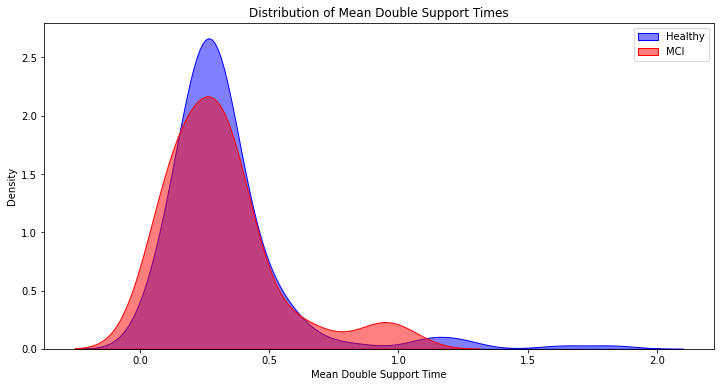

In [22]:
from scipy.stats import ttest_ind

# Perform the t-test
t_stat, p_value = ttest_ind(healthy_df['double_support'].dropna(), mci_df['double_support'].dropna(), equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

import seaborn as sns
import matplotlib.pyplot as plt
# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot healthy subjects
sns.kdeplot(healthy_df['double_support'].dropna(), label='Healthy', fill=True, color='blue', alpha=0.5)
# Plot MCI subjects
sns.kdeplot(mci_df['double_support'].dropna(), label='MCI', fill=True, color='red', alpha=0.5)

# Add titles and labels
plt.title('Distribution of Mean Double Support Times')
plt.xlabel('Mean Double Support Time')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

In [23]:
from scipy.stats import ttest_ind, describe
t_stat, p_val = ttest_ind(healthy_df['double_support'].dropna(), mci_df['double_support'].dropna(), nan_policy='omit')

# Determine the significance level
significance_level = 0.05
significance = "Significant" if p_val < significance_level else "Not Significant"

# Calculate descriptive statistics for each group
desc_healthy = describe(healthy_df['double_support'].dropna())
desc_mci = describe(mci_df['double_support'].dropna())

# Calculate the median for each group
median_healthy = np.median(healthy_df['double_support'].dropna())
median_mci = np.median(mci_df['double_support'].dropna())
results = {'Metric': [], 'Mean_Healthy': [], 'Mean_MCI': [], 'Median_Healthy': [], 'Median_MCI': [], 'Range_Healthy': [], 'Range_MCI': [], 'Std_Healthy': [], 'Std_MCI': [], 'P-value': [], 'Significance': []}
results['Metric'].append('Double Support Time')
results['Mean_Healthy'].append("{:.2f}".format(desc_healthy.mean))
results['Mean_MCI'].append("{:.2f}".format(desc_mci.mean))
results['Median_Healthy'].append("{:.2f}".format(median_healthy))
results['Median_MCI'].append("{:.2f}".format(median_mci))
results['Range_Healthy'].append("({:.2f}, {:.2f})".format(desc_healthy.minmax[0], desc_healthy.minmax[1]))
results['Range_MCI'].append("({:.2f}, {:.2f})".format(desc_mci.minmax[0], desc_mci.minmax[1]))
results['Std_Healthy'].append("{:.2f}".format(desc_healthy.variance ** 0.5))
results['Std_MCI'].append("{:.2f}".format(desc_mci.variance ** 0.5))
results['P-value'].append("{:.2f}".format(p_val))
results['Significance'].append(significance)

results_df = pd.DataFrame(results, index=results['Metric']).drop('Metric', axis=1)
results_df

,Mean_Healthy,Mean_MCI,Median_Healthy,Median_MCI,Range_Healthy,Range_MCI,Std_Healthy,Std_MCI,P-value,Significance
Double Support Time,0.33,0.31,0.28,0.29,"(0.03, 1.83)","(0.08, 0.98)",0.25,0.22,0.69,Not Significant
